## PCA Clustering

In [534]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, ward, complete
import matplotlib.pyplot as plt
%matplotlib inline

In [535]:
def compute_pca(input_dataframe, output_dataframe, max_components):
    # extract metrics and normalize (mean = 0, var =1)
    values = input_dataframe.drop('Description', axis=1)
    values = StandardScaler().fit_transform(values)

    pca = PCA(n_components=max_components)
    pcs = pca.fit_transform(values)
    explained_var = sum(pca.explained_variance_ratio_)
    #print("Explained variance: " + str(explained_var))

    for pc_index, pc in enumerate(pcs):
        for val_index, val in enumerate(pc): 
            column = input_dataframe.name + "PC" + str(val_index+1)
            if not column in output_dataframe.columns:
                output_dataframe[column] = np.nan
            output_dataframe.at[pc_index,column] = val


In [536]:
def compute_and_plot_dendrogram(matrix):
    # CA:
    model = AgglomerativeClustering(affinity='euclidean', linkage='ward', distance_threshold=0, n_clusters=None)
    model = model.fit(matrix)
    fig, ax = plt.subplots(figsize=(8,10))
    plot_dendrogram(model)

def plot_dendrogram(model, **kwargs):
    # CA:
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    global cell_ids
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', labels=cell_ids) 

In [537]:
table_dir = '/home/tferr/code/morphonets/SNT/clustering/zi/'
metrics_table  = 'analyzer-axon.csv'
barcode1_table = 'barcodes-geodesic.csv'
barcode2_table = 'barcodes-radial.csv'
project1_table = 'brain-annot-tips-maxLevel5.csv'
project2_table = 'brain-annot-length-maxLevel5.csv'

def get_dataframe(file):
    df = pd.read_csv(table_dir + file)
    df.name = file[0:3]
    return df

# load dataset as Pandas DataFrame
metrics_df = get_dataframe(metrics_table)
barcode1_df = get_dataframe(barcode1_table)
barcode2_df = get_dataframe(barcode2_table)
project1_df = get_dataframe(project1_table)
project2_df = get_dataframe(project2_table)
#display(metrics_df)


In [538]:
## define groups as per Winnubst et al
known_classes = {}
known_classes["TH"] = ['AA0904', 'AA0610', 'AA0266', 'AA0178']
known_classes["SC"] = ['AA0808', 'AA0443', 'AA0405', 'AA0177']
known_classes["MY"] = ['AA0768', 'AA0175', 'AA0174']
known_classes["??"] = ['AA0389']

cell_ids = metrics_df.loc[:,'Description'].values
for index, cellid in enumerate(cell_ids):
    for key in known_classes:
        for knownid in known_classes[key]:
            if knownid in cellid:
                cell_ids[index] = cellid + " (" + key + ")"

In [539]:
# Which data to consider?
inputs = [metrics_df, project1_df, project2_df]

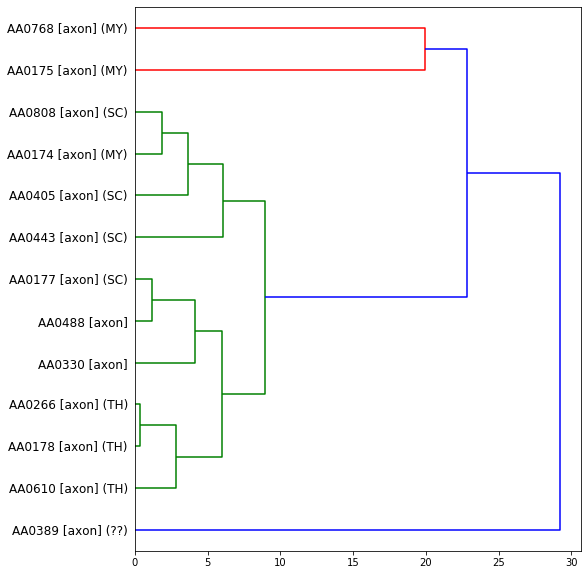

In [540]:
# Choose Components from each category of metrics
all_pcs_df = pd.DataFrame({'Description' : cell_ids})

for input_df in inputs:
    compute_pca(input_df, all_pcs_df, 3)

#display(all_pcs_df)
X = all_pcs_df.drop('Description', axis=1)
compute_and_plot_dendrogram(X)

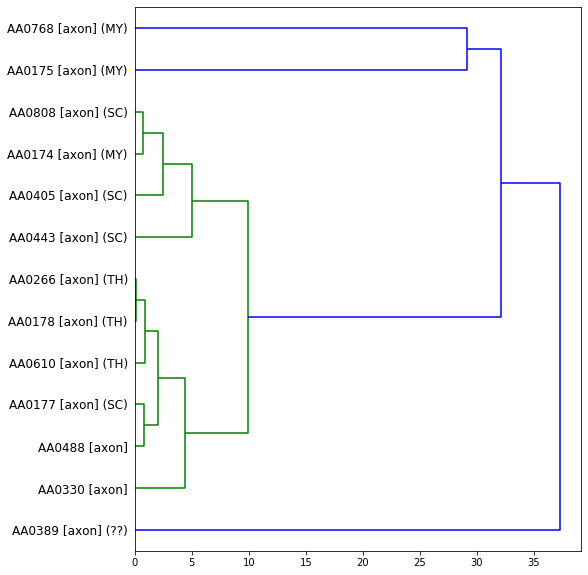

In [541]:
# Operate on all metrics
input_df = pd.concat(inputs, axis=1)
input_df.name = "Merged"
#display(input_df)

all_pcs_df = pd.DataFrame({'Description' : cell_ids})
compute_pca(input_df, all_pcs_df, 3)
#display(all_pcs_df)

X = all_pcs_df.drop('Description', axis=1)
compute_and_plot_dendrogram(X)